<a href="https://colab.research.google.com/github/Ckvalencia/hello-world/blob/master/SHECCO_CMU_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SHECCO methology for CMU subset Mocap data classification**

Here we present how to supplementary material from work titled *Supervised Hilbert embedding based on cross-covariance operator for multichannel Mocap data classification*, the codes corresponding to the activity classification experiment carried out on the CMU subset that appears in the mentioned paper. 


# **1. Loading packages and data**

In [ ]:
#Load the PyMO libary for managment mocap data from: https://github.com/omimo/PyMO
FILEID = "1pRkeyDbjudmvNSph596CA2fgQaQJMbz9" #copiar id de su archivo
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip

In [ ]:
#Load the CMU subset
FILEID = "1gL4ceVWNeojr3L4b06h6x-_GzKvMnDyq" #copiar id de su archivo
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip

In [20]:
import os
import sys
## Auxiliary function path
af_dir ='/content/PyMO-master'
sys.path.append(af_dir)

In [21]:
#Load packages
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import timeit
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report as cr
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#**2. Main  Class corresponding to the compute of the SHECCO metric**

In [46]:
#clase principal shecco
class SHECCO(BaseEstimator,TransformerMixin):
    def __init__(self, sigmax = 54, sigmay = 54, Ax = 1, Ay = 1,ws = 5, noverlap = None, k = 50, sup = 1):
        self.sigmax = sigmax
        self.sigmay = sigmay
        self.ws = ws
        self.noverlap = noverlap
        self.sup = sup
        self.k = k
        self.Ax = Ax
        self.Ay = Ay
    
    def plot_mocap(self, Nfol, Ntrial, ind):
     list_trials = os.listdir('/content/HDM_demo/'+list_folder[Nfol])
     list_trials = sorted(list_trials) 
     mp_p = MocapParameterizer(param_type = 'position')
     data_all = [p.parse('/content/HDM_demo/'+list_folder[Nfol]+'/'+list_trials[Ntrial])]
     pos_d= mp_p.fit_transform(data_all)
     #Normalization
     n=pos_d[0].values
     P = np.asarray(pos_d[0].values)
     z = P.reshape(n.shape[0],38,3)
     Z = np.zeros(z.shape)
     for i in range(z.shape[0]):
       for j in range(z.shape[1]):
         Z[i,j,:] =z[i,j,:]- z[i,0,:]

     #Distance among skeletons
     for k in range(ind.shape[0]):
       for l in range(Z.shape[1]):
         Z[ind[k],l,0]= Z[ind[k],l,0]+20*k
     Z = Z.reshape(n.shape[0],114)
     n.iloc[:]=Z[:]
     pos_d[0].values = n

     if ind.shape[0]<= 10:
       draw_stickfigure(pos_d[0], frame = ind, figsize=(20,4))
     else: 
       nf = int(ind.shape[0]/10)
       for h in range(0,nf):
         draw_stickfigure(pos_d[0], frame = ind[10*h:10*(h+1)], figsize=(20,4))
         plt.show()


    def geneout_(self,X):
      #print(X.shape)
      N,T = X.shape
      Y = np.zeros((N,T))
      for n in range(N):
        for t in range(T-1):
          Y[n,t]=X[n,t+1]
      return Y

    def ventaneo_(self,X):
       N,P = X.shape
       if self.noverlap == None: self.noverlap =0
       if self.ws == None: self.ws = P
       for j in range(N):
         pi = 0
         pf = self.ws
         Xi = X[j,pi:pf].reshape(1,-1) 
         Yi = X[j,pf].reshape(1,-1)
         pi = pi + (self.ws - self.noverlap)
         pf = pi +self.ws
         while pf  < P:
                Xi = np.r_[Xi,X[j,pi:pf].reshape(1,-1)]
                Yi = np.r_[Yi,X[j,pf].reshape(1,-1)]
                pi = pi + (self.ws - self.noverlap)
                pf = pi +self.ws
                #print(Xi,Yi)
         #print(pi,pf)
         if pf >= P:
            temp = X[j,pi:].reshape(1,-1)
            Xi = np.r_[Xi,np.c_[temp,np.zeros(self.ws-temp.shape[1]).reshape(1,-1)]]
            Yi = np.r_[Yi,np.zeros(1).reshape(-1,1)]       
         if j == 0: 
           #print(Xi.shape)
           X_ = np.zeros((N,Xi.shape[0],Xi.shape[1]))
           Y_ = np.zeros((N,Yi.shape[0],1))
         X_[j] = Xi  
         Y_[j] = Yi  
       return X_,Y_  

    def SC_(self,X,Y):
        Xcl = np.zeros((X.shape[0], self.k))
        Ycl = np.zeros((Y.shape[0], self.k))
        for n in range(X.shape[0]):
            Z = X[n]
            L = Y[n]
            Z = np.tile(Z,(Z.shape[0],1))
            D = pairwise_distances(Z,Z)
            gamma = 1/(np.median(D)**2)
            K = np.exp(-0.5*gamma*D**2)
            Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
            y_pred = Clus.fit_predict(K)
            centers = np.zeros((self.k,Z.shape[1]))
            for c in range(self.k):
                centers[c] = Z[y_pred==c].mean(axis=0)
                
            Ds = pairwise_distances(centers,Z)
            ind = np.argmin(Ds,axis=1) 
            Xcl[n] = Z[ind]
            Ycl[n] = L[ind]
        return Xcl,Ycl

    def SC_Mocap(self,X,Y):
      Xcl = np.zeros((self.k, X.shape[1]))
      Ycl = np.zeros((self.k, Y.shape[1]))
      D = pairwise_distances(Y,Y)
      gamma = 1/(np.median(D)**2)
      K = np.exp(-0.5*gamma*D**2)
      Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
      y_pred = Clus.fit_predict(K)
      centers = np.zeros((self.k,Y.shape[1]))
      for c in range(self.k):
        centers[c] = Y[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,Y)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      Ycl = Y[ind]
      return Xcl,Ycl,ind


    def Kmeans_Mocap(self,X):
      Xcl = np.zeros((self.k, X.shape[1]))
      #Ycl = np.zeros((self.k, Y.shape[1]))
      #Clus = KMeans(n_clusters= self.k, random_state=0)
      y_pred = KMeans(n_clusters= self.k, random_state=0).fit_predict(X)
      centers = np.zeros((self.k,X.shape[1]))
      for c in range(self.k):
        centers[c] = X[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,X)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      #Ycl = Y[ind]
      return Xcl,ind

    def kergM(self,X,Y,sigma_,A):
       return A*np.exp(-pairwise_distances(X,Y)**2/(2*sigma_**2))
    
    def shecco_(self,X,Y,Z,L,pxx,pyy,pzz,pll,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1)#.dot(pxx.reshape(1,-1))
          PYY = pyy.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZZ = pzz.reshape(-1,1)#.dot(pzz.reshape(1,-1))  
          PLL = pll.reshape(-1,1)#.dot(pll.reshape(1,-1))  
          PXY = pxx.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZL = pzz.reshape(-1,1)#.dot(pll.reshape(1,-1))  
      KXX  = self.kergM(X,X,self.sigmax,self.Ax)
      KZZ  = self.kergM(Z,Z,self.sigmax,self.Ax)
      KYY  = self.kergM(Y,Y,self.sigmay,self.Ay)
      KLL  = self.kergM(L,L,self.sigmay,self.Ay)
      KXZ  = self.kergM(X,Z,self.sigmax,self.Ax)
      KYL  = self.kergM(Y,L,self.sigmay,self.Ay)


      #trxx=KXX.shape[0]**2 #np.sqrt(np.trace((KXX.dot(KXX))))
  
      #trzz=KZZ.shape[0]**2#np.sqrt(np.trace((KZZ.dot(KZZ))))
    
      #tryy=KYY.shape[0]**2#np.sqrt(np.trace((KYY.dot(KYY))))
     
      #trll=KLL.shape[0]**2#np.sqrt(np.trace((KLL.dot(KLL))))
    
      #trxz=KXX.shape[0]*KZZ.shape[0]#np.sqrt(np.trace((KXZ.dot(KXZ.T))))
     
      #tryl=KYY.shape[0]*KLL.shape[0]#np.sqrt(np.trace((KYL.dot(KYL.T))))
      #KXX = KXX*trxx
      #KZZ = KZZ*trzz
      #KYY = KYY*tryy
      #KLL = KLL*trll
      #KXZ = KXZ*trxz
      #KYL = KYL*tryl
     
      #d = np.trace((PXX*KXX).dot(KYY*PYY)) -2*np.trace((PXZ*KXZ).dot((KYL*PYL).T)) + np.trace((PZZ*KZZ).dot(KLL*PLL))
      d = (PXY.T).dot(KXX*KYY).dot(PXY) -2*(PXY.T).dot(KXZ*KYL).dot(PZL) + (PZL.T).dot(KZZ*KLL).dot(PZL)

      if d<0:
        d = abs(d)
      return d

    #hecco sin salida (no supervised)
    def hecco_(self,X,Z,pxx,pzz,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1).dot(pxx.reshape(1,-1))
          PZZ = pzz.reshape(-1,1).dot(pzz.reshape(1,-1))   
          PXZ = pxx.reshape(-1,1).dot(pzz.reshape(1,-1)) 
      KXX  = self.kergM(X,X,self.sigmax)
      KZZ  = self.kergM(Z,Z,self.sigmax)
      KXZ  = self.kergM(X,Z,self.sigmax)
      
      d = np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXX*KXX)),np.ones(PXX.shape[0]))-2*np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXZ*KXZ)),np.ones(PZZ.shape[0]))+ np.dot(np.dot(np.ones(PZZ.shape[0]).T,(PXX*KXX)),np.ones(PZZ.shape[0]))
     
      if d<0:
        d = abs(d)
      return d   

    def SHECCO_M_(self,Xtrain_,Xtest_,Ytrain_,Ytest_,pzz,pll):
      Ntrain = Xtrain_.shape[0]
      Ntest = Xtest_.shape[0]
        
      Dte_tr = np.zeros((Ntest,Ntrain))
      for i in range(Ntrain):
        for j in range(Ntest):
          if self.sup == None:
              Dte_tr[j,i] = self.hecco_(Xtrain_[i],Xtest_[j],self.pxx,pzz)
          else:
            Dte_tr[j,i] = self.shecco_(Xtrain_[i],Ytrain_[i],Xtest_[j],Ytest_[j],
                       self.pxx,self.pyy,pzz,pll)
      return Dte_tr

    def fit(self,X,*_):
        #self.Xtrain_,self.Ytrain_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
           # self.Xtrain_, self.Ytrain_= self.SC_(self.Xtrain_,self.Ytrain_)
        self.Xtrain_= X
        Ya = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Ya[i,:,:]= L.T
        Yp = Ya.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Ytr = pca.fit(Yp).transform(Yp)  
        Y = Ytr.reshape(X.shape[0], X.shape[1], Ytr.shape[1])
        self.Ytrain_= Y
        self.N = self.Xtrain_.shape[1]
        #estimar pdfs
        self.pxx = (1/self.N)*np.ones(self.N) #prob uniformes
        self.pyy = (1/self.N)*np.ones(self.N)
        return self

    def transform(self,X): #Xt_=[Xt,Yt]
        #Xtest_,Ytest_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
        Xtest_ = X
        Yb = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Yb[i,:,:]= L.T
        Yp = Yb.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Yte = pca.fit(Yp).transform(Yp)  
        Y = Yte.reshape(X.shape[0], X.shape[1], Yte.shape[1])
        Ytest_ = Y
        M = Xtest_.shape[1]
        #estimar pdfs
        pzz = (1/M)*np.ones(M) #porbas uniformes
        pll = (1/M)*np.ones(M)
        return self.SHECCO_M_(self.Xtrain_,Xtest_,self.Ytrain_,Ytest_,pzz,pll)

    def fit_tranform(self,X):
        self.fit(X)
        return self.transform(X)

In [23]:
#The data directory is established
list_folder = os.listdir('/content/cmu-subset/')
list_folder = sorted(list_folder)
list_folder

# **3. Data is loaded and skeletons and trajectories are extracted using the PyMO library**

In [26]:
p = BVHParser()
mp = MocapParameterizer(param_type = 'position')
pos_cent = {}
list_folder = os.listdir('/content/cmu-subset/')
k = 0
labels_subj = np.zeros((204))
for i in range(len(list_folder)):
  list_trials = os.listdir('/content/cmu-subset/'+list_folder[i])
  list_trials = sorted(list_trials)
  for j in range(len(list_trials)):
    labels_subj[k] = list_trials[j][4:6]        
    data_all = [p.parse('/content/cmu-subset/'+list_folder[i]+'/'+list_trials[j])]
    #labels_subj = 
    pos_cent[k] = mp.fit_transform(data_all)
    k = k+1

# **4. The data of each frame is normalized with respect to the hip joint**

In [28]:
#Normalization with respect to hips positions
for k in range(len(pos_cent)): 
  n=pos_cent[k][0].values
  P = np.asarray(n)
  X = P.reshape(n.shape[0],38,3)
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j,:] =X[i,j,:]- X[i,0,:]
  Z = Z.reshape(n.shape[0],114)   
  n.iloc[:]=Z[:]
  pos_cent[k][0].values = n

# **5. The clustering process is executed using the K-means algorithm in order to obtain the most relevant frames**

In [29]:
#Clustering positions
start = timeit.timeit()
k=50
dist = SHECCO(k=k)
Xa = np.zeros((len(pos_cent),k,114))
ind = np.zeros((len(pos_cent),k))
for i in range(len(pos_cent)):
  Z = np.array(pos_cent[i][0].values)
  Xc,indx = dist.Kmeans_Mocap(Z)
  Xa[i,:,:]= Xc
  ind[i,:] = indx
end = timeit.timeit()
print(end-start)
ind=ind.astype(int)

0.009127749999606749


# **6. A 2D projection is made, through PCA, of the frames obtained in the grouping process**

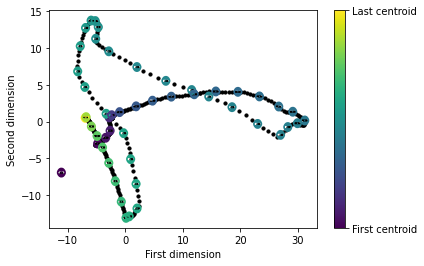

In [30]:
v = 90
Z = pos_cent[v][0].values
pca = PCA(n_components=2)
x = pca.fit(Z).transform(Z)
plt.scatter(x[:, 0], x[:, 1],color='k', s=10)
plt.scatter(x[ind[v], 0], x[ind[v], 1], marker='d', s=2, linewidths=8,c=ind[v])
a = plt.colorbar()
a.set_ticks([np.min(ind[v]),np.max(ind[v])])
a.set_ticklabels(['First centroid','Last centroid'])
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
#for j in range(ind.shape[1]):
 #plt.text(x[ind[v,j], 0], x[ind[v,j], 1], ind[v,j], fontsize=12,color = 'r')
#plt.savefig('Volley.pdf', bbox_inches='tight')
plt.savefig('throw_pca.pdf', bbox_inches='tight')
plt.show()

In [32]:
# We define the name of the labels according to the type of activity
list_mov = ['wal', 'run', 'sit', 'jum', 'wei', 'cli', 'swn', 'plb', 'plt', 'kic', 'soc', 'box', 'swm', 'sal', 'InB']

# **7. We construct the vector of labels and adjust the parameters of the characteristic kernels**

In [33]:
#Labels is built
X = []
nlabs = []
filename = 'Data_clus_CMU_demo'
for j in range(len(list_folder)):
  list_trials = os.listdir('/content/cmu-subset/'+list_folder[j])
  list_trials = sorted(list_trials)
  for i in range(len(list_trials)):
    X += [Xa[i]]
  nlabs += [len(list_trials)]
labels = np.repeat(list_folder, nlabs, axis=0)
labels_name = np.repeat(list_mov, nlabs, axis=0)
labels = labels.reshape(-1,1) 
labels_name = labels_name.reshape(-1,1)   
X+=[labels]
joblib.dump(X,filename+".pkl")

['Data_clus_CMU_demo.pkl']

In [34]:
# Sigma parameters is computed
Sigx = np.zeros((Xa.shape[0]))
#Sigy = np.zeros((Y.shape[0]))
for i in range(Xa.shape[0]):
  Dx = pairwise_distances(Xa[i],Xa[i])
  Sigx[i] = np.median(Dx)
  #Dy = pairwise_distances(Y[i],Y[i])
  #Sigy[i] = np.median(Dy)
Sigma_x = np.median(Sigx)
Sigma_y = Sigma_x

# **8. We calculate and graph the dissimilarity matrix from SHECCO**

In [47]:
#Compute the distances matrix
dist = SHECCO(sigmax=Sigma_x, sigmay=Sigma_y, Ax = k, Ay = k)
D = dist.fit_transform(Xa)

In [48]:
D.shape

(204, 204)

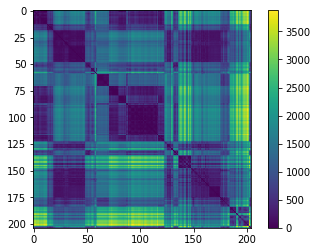

In [49]:
#Graph the dissimilarity matrix
plt.imshow(D)
plt.colorbar()
#plt.savefig('distance_HDM.pdf', bbox_inches='tight')
plt.show()

# **9. We visualize the space generated by the dissimilarity matrix using TSNE**

No handles with labels found to put in legend.


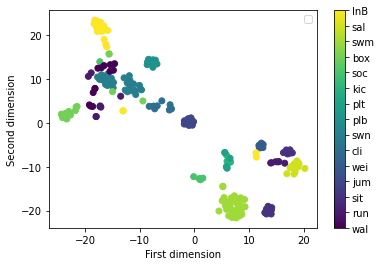

In [52]:
#visualizar espacio generado por las distancias con tsne
red = TSNE(metric='precomputed',perplexity=20.0) # tsne asume que la entrada es una matriz de distancias, preplexity = #vecinos = entropia por vecindarios
ztrain = red.fit_transform(D)
plt.scatter(ztrain[:,0],ztrain[:,1],c=labels)
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
a = plt.colorbar()
a.set_ticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15])
a.set_ticklabels(list_mov)
plt.savefig('TSNE_CMU.pdf', bbox_inches='tight')
plt.legend()

# **10. We adjust the parameters associated with the classifier based on an SVM**

In [55]:
  steps=[('pre',  StandardScaler()),
         ('svc', SVC(kernel='rbf'))] 
  parameters = {                   
                'svc__C': [1 ,10,100,1000,10000],
                'svc__gamma': [0.01,0.1,1,100,1000]    
               }

  label_model = ['SHECCO_SVC']

In [56]:
#crear carpeta con resultados
import os
try:
  os.mkdir('datos')
except:
  print("Carpeta results ya existe")

Carpeta results ya existe


# **11. We execute the training and validation processes of the classifier, in addition we adjust the parameters using cross validation**

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit
#Global variables
N = D.shape[0]
Niter = 10
per_test     = 0.2
n_classes    = len(np.unique(labels))
acc     = np.zeros((Niter))
cmc           = np.zeros((Niter,n_classes,n_classes))
best_estimators = []#mejor metodo por iteracion
best_parameters = []#mejor metodo por iteracion
y = labels_name

v_sigmax = [0.5*Sigma_x , Sigma_x , 2*Sigma_x, 5*Sigma_x,10*Sigma_x]
v_sigmay = [0.5*Sigma_y , Sigma_y , 2*Sigma_y, 5*Sigma_y,10*Sigma_y]
#v_sigmax = [0.1, 1,10,100,200,500,1000]
#v_sigmay = [0.1, 1,10,100,200,500,1000]

Cms  = np.zeros((len(v_sigmax)*len(v_sigmay),len(np.unique(y)),len(np.unique(y))))
Cmstd  = np.zeros((len(v_sigmax)*len(v_sigmay),len(np.unique(y)),len(np.unique(y))))
accms  = np.zeros((len(v_sigmax)*len(v_sigmay),2))
sigmaM = np.zeros((len(v_sigmax)*len(v_sigmay),2))

#main loop

i = 0
sss = StratifiedShuffleSplit(n_splits=Niter, test_size=per_test, random_state=0)
for Sigma_xi,Sigma_yi in zip(v_sigmax,v_sigmay):
    print('iter %d/%d' % (i+1,Cms.shape[0]))
    print('Sigmax=%.2e; Sigmay=%.2e' % (Sigma_xi, Sigma_yi))
    sigmaM[i] = np.array([Sigma_xi,Sigma_yi])

    dist = SHECCO(sigmax=Sigma_xi, sigmay=Sigma_yi, Ax = k, Ay = k)
    D = dist.fit_transform(Xa)
    
    j = 0
    for train_index, test_index in sss.split(D, y):
        X_train = D[train_index]
        X_train = X_train[:,train_index]
        y_train = y[train_index]
        X_test = D[test_index]
        X_test = X_test[:,train_index]     
        y_test = y[test_index]
        grid_search = GridSearchCV(Pipeline(steps),parameters,cv=5,verbose=0,scoring='accuracy',n_jobs=-1)
        #generar mejor modelo
        grid_search.fit(X_train,y_train)
        #estimar salida conjunto de test
        y_pred = grid_search.best_estimator_.predict(X_test)
        #guardar mejor modelo
        best_estimators.append(grid_search.best_estimator_)
        best_parameters.append(grid_search.best_params_)
        
        #guardar acierto
        acc[j] = 100*accuracy_score(y_test,y_pred)
        #estimar matriz de confusion
        cm = confusion_matrix(y_test, y_pred)
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmc[j] = cm
        j+=1
        #print('it %d/%d'%(j+1,Niter))
        #print(grid_search.best_params_)
        
    Cms[i] = cmc.mean(axis=0)
    Cmstd[i] = cmc.std(axis=0)
    accms[i,0] = acc.mean()
    accms[i,1] = acc.std()
    print('acc=$%.2f\pm%.2f' % (accms[i,0],accms[i,1]))
    print('confusionmatrix \n',np.array_str(Cms[i], precision=2))
    i+=1

iter 1/25
Sigmax=1.85e+01; Sigmay=1.85e+01
acc=$91.71\pm4.25
confusionmatrix 
 [[ 75.     0.     0.     0.     0.     5.     0.    12.5    0.     0.
    7.5    0.     0.     0.     0.  ]
 [  0.   100.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.   100.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.    80.    20.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.    20.    80.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     3.33  96.67   0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  3.33  16.67   0.     0.     0.     0.    73.33   0.     0.     0.
    6.67   0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.   100.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     5.     0.  

In [ ]:
#The best results
imax = np.argmax(accms[:,0])
print('acc=$%.2f\pm%.2f' % (accms[imax,0],accms[imax,1]))
print('confusionmatrix \n',Cms[imax])
print('Sigx=%.2e, Sigy=%.2e' % (sigmaM[imax,0],sigmaM[imax,1]))

## **12. We construct and graph the confusion matrix of the previous classification**

In [ ]:
#id del archivo: 1sui-FJI5znNJuQOk0whM6PALI89XfKss
FILEID = "1sui-FJI5znNJuQOk0whM6PALI89XfKss"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir
!pip install mne==0.19

In [60]:
import sys
#agregar carpeta con funciones
sys.path.insert(1, './CodesBCIITL')
%matplotlib inline
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne
####################################################
#clase principal reduccion de dimension con kernels
from MiniBatchCKA import MiniBatchCKA # Aqui importar la funcion de reduccion con itl
###################################################

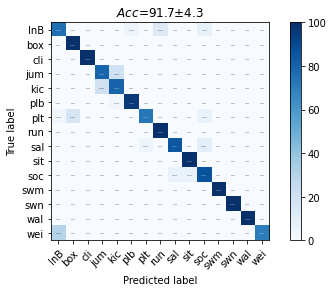

In [68]:
plot_confusion_matrix_MS(Cms[imax], Cmstd[imax], np.unique(y))
plt.title('${Acc}$='+ format(accms[imax,0],'.1f') +'$\pm$'+ format(accms[imax,1],'.1f'))
plt.autoscale
#plt.xticks([0,1,2,3],list_folder)
#plt.yticks([0,1,2,3],list_folder)
#plt.savefig('acc_svm.pdf', bbox_inches='tight')
plt.savefig('acc_CMU.pdf', bbox_inches='tight')
plt.show()
#print(best_parameters)